<a href="https://colab.research.google.com/github/evangrinalds/DS-Unit-4-Sprint-1-NLP/blob/main/module2-vector-representations/LS_DS18_412_Vector_Representations_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 4, Sprint 1, Module 2*

---

# Vector Representations (Prepare)


As we learned yesterday, machines cannot interpret raw text. We need to transform that text into something we/machines can more readily analyze. Yesterday, we did simple counts of counts to summarize the content of Amazon reviews. Today, we'll extend those concepts to talk about vector representations such as Bag of Words (BoW) and word embedding models. We'll use those representations for search, visualization, and prepare for our classification day tomorrow. 

Processing text data to prepare it for machine learning models often means translating the information from documents into a numerical format. Bag-of-Words approaches (sometimes referred to as Frequency-Based word embeddings) accomplish this by "vectorizing" tokenized documents. This is done by representing each document as a row in a DataFrame and creating a column for each unique word in the corpora (group of documents). The presence or lack of a given word in a document is then represented either as a raw count of how many times a given word appears in a document (CountVectorizer) or as that word's TF-IDF score (TfidfVectorizer).

On the python side, we will be focusing on `sklearn` and `spacy` today.  

## Case Study

We're going to pretend we're on the datascience team at the BBC. We want to recommend articles to visitors to on the BBC website based on the article they just read. Our team wants 

**Dataset:**

[D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.](http://mlg.ucd.ie/datasets/bbc.html)
*Please note that the dataset has been sampled down to tech articles only.* 

## Learning Objectives
* <a href="#p1">Part 1</a>: Represent a document as a vector
* <a href="#p2">Part 2</a>: Query Documents by Similarity
* <a href="#p3">Part 3</a>: Apply word embedding models to create document vectors

# Represent a document as a vector (Learn)
<a id="p1"></a>

## Overview

In this section, we are going to create Document Term Matrices (DTM). Each column represents a word. Each row represents a document. The value in each cell can be range of different things. The most traditional: counts of appearances of words, does the word appear at all (binary), and term-frequency inverse-document frequency (TF-IDF). 

**Discussion:** Don't we loose all the context and grammar if we do this? So Why does it work?

## Follow Along

In [ ]:
# Dependencies for the week (instead of conda)
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
!pip install -r requirements.txt

--2020-09-29 15:49:53--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     137  --.-KB/s    in 0s      

2020-09-29 15:49:54 (8.43 MB/s) - ‘requirements.txt’ saved [137/137]

     |████████████████████████████████| 24.2MB 170kB/s 
     |████████████████████████████████| 1.6MB 51.1MB/s 
     |████████████████████████████████| 10.4MB 48.3MB/s 
     |████████████████████████████████| 7.1MB 51.5MB/s 
     |████████████████████████████████| 215kB 40.5MB/s 
     |████████████████████████████████| 2.2MB 41.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.w

In [ ]:
!python -m spacy download en_core_web_lg  # Can do lg, takes awhile
# Also on Colab, need to restart runtime after this step!

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=82e4581b799fe84368b650a5f1973b341f008e9f9e26a1f4c75a534a3d8d0c97
  Stored in directory: /tmp/pip-ephem-wheel-cache-5p5d8f5t/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
""" Import Statements """

# Classics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
nlp = spacy.load("en_core_web_lg")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Warm Up (_3 Minutes_)**

Extract the tokens from this sentence using Spacy. Text is from [OpenAI](https://openai.com/blog/better-language-models/)

In [ ]:
text = ("We created a new dataset which emphasizes diversity of content, by "
  "scraping content from the Internet. In order to preserve document quality, "
  "we used only pages which have been curated/filtered by humans—specifically, "
  "we used outbound links from Reddit which received at least 3 karma. "
  "This can be thought of as a heuristic indicator for whether other users "
  "found the link interesting (whether educational or funny), leading to "
  "higher data quality than other similar datasets, such as CommonCrawl.")

In [ ]:
text

'We created a new dataset which emphasizes diversity of content, by scraping content from the Internet. In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma. This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny), leading to higher data quality than other similar datasets, such as CommonCrawl.'

In [ ]:
doc = nlp(text)

print([token.lemma_ for token in doc if (token.is_stop != True) and
       (token.is_punct != True)])

['create', 'new', 'dataset', 'emphasize', 'diversity', 'content', 'scrape', 'content', 'internet', 'order', 'preserve', 'document', 'quality', 'page', 'curate', 'filter', 'human', 'specifically', 'outbound', 'link', 'Reddit', 'receive', '3', 'karma', 'think', 'heuristic', 'indicator', 'user', 'find', 'link', 'interesting', 'educational', 'funny', 'lead', 'high', 'datum', 'quality', 'similar', 'dataset', 'CommonCrawl']


In [ ]:
import os 

def gather_data(filefolder):
    """ Produces List of Documents from a Directory
    
    filefolder (str): a path of .txt files
    
    returns list of strings 
    """
    data = []
    files = os.listdir(filefolder) # Causes variation across machines
    
    for article in files: 
        path = os.path.join(filefolder, article)         
        if  path[-3:] == 'txt': # os ~endswith('txt')
            with open(path, 'rb') as f:
                data.append(f.read())
    
    return data

In [ ]:
!wget https://github.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/raw/main/module2-vector-representations/data.zip

--2020-09-29 15:53:40--  https://github.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/raw/main/module2-vector-representations/data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/module2-vector-representations/data.zip [following]
--2020-09-29 15:53:40--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/module2-vector-representations/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1142153 (1.1M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1.09M  --.-KB/s    in 0.1s    

2020-09-29 1

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/289.txt            
  inflating: data/262.txt            
  inflating: data/276.txt            
  inflating: data/060.txt            
  inflating: data/074.txt            
  inflating: data/048.txt            
  inflating: data/114.txt            
  inflating: data/100.txt            
  inflating: data/128.txt            
  inflating: data/316.txt            
  inflating: data/302.txt            
  inflating: data/303.txt            
  inflating: data/317.txt            
  inflating: data/129.txt            
  inflating: data/101.txt            
  inflating: data/115.txt            
  inflating: data/049.txt            
  inflating: data/075.txt            
  inflating: data/061.txt            
  inflating: data/277.txt            
  inflating: data/263.txt            
  inflating: data/288.txt            
  inflating: data/275.txt            
  inflating: data/261.txt            
  inflating: data/249.txt            
  inflating:

In [ ]:
data = gather_data('./data')

In [ ]:
data[0]

b'More movies head to Sony\'s PSP\n\nMovies Open Water and Saw are among those to be made available for Sony\'s PSP games console.\n\nFilm studio Lions Gate entertainment has announced an initial list of 12 movies that will be on the UMD format used by the handheld. "The typical buyer of the machine [is] the core demographic to whom our films generally appeal," said Steve Beeks, president of Lions Gate. Already available in Japan, the PSP is released in the US on 24 March. Spider-Man 2 on UMD will be given to the first million customers in the US.\n\nThe Punisher and House of the Dead along with older titles such as Total Recall and Rambo: First Blood, will be in the UMD format, with disks costing between $20 (\xc2\xa310.40) to $30 (\xc2\xa315.60) for new titles and $10 (\xc2\xa35.20) to $20 for older films.\n\n"When we first saw the machine and started talking to Sony, we immediately decided it was going to be a winner, both from the gaming perspective and from the perspective of peop

### CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# list of text documents
text = ["We created a new dataset which emphasizes diversity of content, by scraping content from the Internet.",
        " In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma.",
        " This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny), leading to higher data quality than other similar datasets, such as CommonCrawl."]

# create the transformer
vect = CountVectorizer()

# build vocab
vect.fit(text)

# transform text
dtm = vect.transform(text)

# Create a Vocabulary
# The vocabulary establishes all of the possible words that we might use.

# The vocabulary dictionary does not represent the counts of words!!


In [ ]:
len(text)

3

In [ ]:
dir(vect)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_char_ngrams',
 '_char_wb_ngrams',
 '_check_stop_words_consistency',
 '_check_vocabulary',
 '_count_vocab',
 '_get_param_names',
 '_get_tags',
 '_limit_features',
 '_more_tags',
 '_sort_features',
 '_stop_words_id',
 '_validate_custom_analyzer',
 '_validate_params',
 '_validate_vocabulary',
 '_warn_for_unused_params',
 '_white_spaces',
 '_word_ngrams',
 'analyzer',
 'binary',
 'build_analyzer',
 'build_preprocessor',
 'build_tokenizer',
 'decode',
 'decode_error',
 'dtype',
 'encoding',
 'fit',
 'fit_transform',
 'fixed_vocabulary_',
 'get_feature_names',
 'get_params',
 'get_stop_words'

In [ ]:
print(dtm)

  (0, 4)	1
  (0, 7)	2
  (0, 8)	1
  (0, 11)	1
  (0, 13)	1
  (0, 16)	1
  (0, 20)	1
  (0, 29)	1
  (0, 35)	1
  (0, 36)	1
  (0, 47)	1
  (0, 52)	1
  (0, 58)	1
  (0, 60)	1
  (1, 1)	1
  (1, 3)	1
  (1, 4)	1
  (1, 9)	1
  (1, 14)	1
  (1, 17)	1
  (1, 20)	1
  (1, 22)	1
  (1, 25)	1
  (1, 26)	1
  (1, 30)	1
  :	:
  (2, 10)	1
  (2, 12)	1
  (2, 15)	1
  (2, 18)	1
  (2, 19)	1
  (2, 21)	1
  (2, 23)	1
  (2, 24)	1
  (2, 27)	1
  (2, 28)	1
  (2, 31)	1
  (2, 33)	1
  (2, 36)	1
  (2, 38)	1
  (2, 40)	2
  (2, 44)	1
  (2, 48)	1
  (2, 50)	1
  (2, 51)	1
  (2, 52)	1
  (2, 53)	1
  (2, 54)	1
  (2, 55)	1
  (2, 57)	1
  (2, 59)	2


In [ ]:
type(dtm.todense())

numpy.matrix

In [ ]:
print(vect.get_feature_names())

['as', 'at', 'be', 'been', 'by', 'can', 'commoncrawl', 'content', 'created', 'curated', 'data', 'dataset', 'datasets', 'diversity', 'document', 'educational', 'emphasizes', 'filtered', 'for', 'found', 'from', 'funny', 'have', 'heuristic', 'higher', 'humans', 'in', 'indicator', 'interesting', 'internet', 'karma', 'leading', 'least', 'link', 'links', 'new', 'of', 'only', 'or', 'order', 'other', 'outbound', 'pages', 'preserve', 'quality', 'received', 'reddit', 'scraping', 'similar', 'specifically', 'such', 'than', 'the', 'this', 'thought', 'to', 'used', 'users', 'we', 'whether', 'which']


In [ ]:
text[:25]

['We created a new dataset which emphasizes diversity of content, by scraping content from the Internet.',
 ' In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma.',
 ' This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny), leading to higher data quality than other similar datasets, such as CommonCrawl.']

In [ ]:
# Dealing with Sparse Matrix
dtm.todense()

matrix([[0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
         0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
         1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2],
        [2, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
         1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 2, 0,
         0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0]])

In [ ]:
# Get Word Counts for each document - making this easier to work with
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm

,as,at,be,been,by,can,commoncrawl,content,created,curated,data,dataset,datasets,diversity,document,educational,emphasizes,filtered,for,found,from,funny,have,heuristic,higher,humans,in,indicator,interesting,internet,karma,leading,least,link,links,new,of,only,or,order,other,outbound,pages,preserve,quality,received,reddit,scraping,similar,specifically,such,than,the,this,thought,to,used,users,we,whether,which
0,0,0,0,0,1,0,0,2,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1
1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0,1,1,1,1,1,1,0,0,1,0,0,0,0,0,1,2,0,2,0,2
2,2,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,1,0,1,0,1,1,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,2,0,0,0,1,0,0,0,1,0,1,1,1,1,1,1,0,1,0,2,0


In [ ]:
dtm.shape

(3, 61)

In [ ]:
type(dtm)

pandas.core.frame.DataFrame

In [ ]:
data[0][:25]

b"More movies head to Sony'"

In [ ]:
len(data)

401

**Three Minute Challenge:** 
* Apply CountVectorizer to our BBC Data
* Store results in a dataframe called `dtm`
* Extra Challenge - Try to Customize CountVectorizer with Spacy Processing

In [ ]:
# Apply CountVectorizer to our Data
# Use custom Spacy Vectorizer
# BBC articles in `data` variable

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english', max_features=1000)

#Learn our Vocab
vect.fit(data)

# Get sparse dtm
dtm = vect.transform(data)

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

In [ ]:
dtm.head()

,000,10,100,11,12,14,15,18,20,200,2003,2004,2005,2006,25,30,3d,3g,40,50,500,60,80,ability,able,access,according,account,accounts,act,action,activity,actually,add,added,address,addresses,advantage,age,ago,...,wanted,wants,warned,warning,wars,watch,watching,way,ways,web,website,websites,week,weeks,went,wi,wide,widely,win,windows,wireless,women,won,word,words,work,worked,working,works,world,worldwide,worm,worth,writing,xbox,xp,yahoo,year,years,york
0,0,2,0,0,1,0,1,0,3,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,5,4,2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
data[3]

b"Who do you think you are?\n\nThe real danger is not what happens to your data as it crosses the net, argues analyst Bill Thompson. It is what happens when it arrives at the other end.\n\nThe Financial Services Authority has warned banks and other financial institutions that members of criminal gangs may be applying for jobs which give them access to confidential customer data. The fear is not that they will steal money from our bank accounts but that they will instead steal something far more valuable in our digital society - our identities. Armed with the personal details that a bank holds, plus a fake letter or two, it is apparently easy to get a loan, open a bank account with an overdraft or get a credit card in someone else's name. And it is then a simple matter to move the money into another account and leave the unwitting victim to sort out the mess when statements and demands for payment start arriving. Identity theft is an increasingly significant economic crime, and we are a

In [ ]:
doc_len = [len(doc) for doc in data]

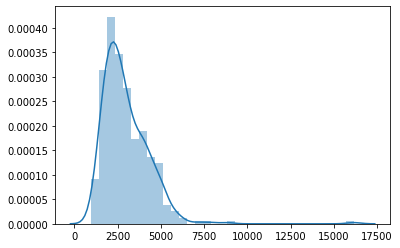

In [ ]:
import seaborn as sns

sns.distplot(doc_len);

### TfidfVectorizer

## Term Frequency - Inverse Document Frequency (TF-IDF)

<center><img src="https://mungingdata.files.wordpress.com/2017/11/equation.png?w=430&h=336" width="300"></center>

Term Frequency: Percentage of words in document for each word

Document Frequency: A penalty for the word existing in a high number of documents.

The purpose of TF-IDF is to find what is **unique** to each document. Because of this we will penalize the term frequencies of words that are common across all documents which will allow for each document's most different topics to rise to the top.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
#tfidf = TfidfVectorizer(max_features=1000)  # To compare to above

# Create a vocabulary and get word counts per document
# Similiar to fit_predict
dtm = tfidf.fit_transform(data)

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,000,10,100,101,104,10m,11,12,120,13,130,14,149,15,150,16,167,17,17m,18,19,1980s,1982,1983,1985,1990s,1993,1994,1995,1bn,1m,20,200,2000,2001,2002,2003,2004,2005,2006,...,worry,worrying,worse,worst,worth,worthwhile,wouldn,wow,wright,wristwatch,write,writer,writers,writing,written,wrong,wrongful,wrote,wsis,x1,xbox,xenon,xp,xxx,yahoo,yang,year,years,yen,yes,yoda,yoran,york,young,younger,youngsters,youth,zafi,zen,zombies
0,0.0,0.083880,0.0,0.0,0.0,0.0,0.0,0.053662,0.0,0.0,0.0,0.0,0.0,0.05477,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153973,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092497,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.08989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.057383,0.057383,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.023269,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.021169,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.027377,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.039228,0.047342,0.000000,0.000000,0.0,0.0,0.028493,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060379,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.045416,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def tokenize(document):
    doc = nlp(document)
    
    # More cleaning
    return [token.lemma_.strip() for token in doc if (token.is_stop != True)
            and (token.is_punct != True)]

text data machines

"text data" "data machines" "text machines"

In [ ]:
# Tunning Parameters

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,2),
                        max_df=.97,
                        min_df=3,
                        tokenizer=tokenize)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(data) # Similiar to fit_predict

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,10,15,2004,50,ability,accord,add,airline,announce,anti,apple,ask,award,basic,bbc,bid,big,body,britain,broadband,bt,build,buy,camera,campaign,cash,certainly,cheap,clark,company,computer,consumer,cost,couple,critical,current,currently,desktop,despite,digital,...,year think,year time,year uk,year use,year year,yen,yen $,yepp,yes,york,york base,york state,york times,young,young americans,young people,young user,youngster,youth,zelda,zen,zen micro,zombie,zombie bot,zone,zoom,£,"£ 1,000","£ 1,152",£ 10,£ 11.5,£ 132,"£ 2,000",£ 20,£ 339,£ 4.99,£ 40,£ 5,£ 50,£ 99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040987,0.054491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dtm.shape

(401, 8218)

## Challenge

During this module's project assignment, you will transform data science job listings to vector representations for analysis downstream. 

# Query Documents by Similarity (Learn)
<a id="p2"></a>

## Overview

Have you ever considered how a search bar works? You may just think that search bars simply match your input text againist the documents. While there are many different mechanisms for the 'match', one of the most classic is to search by similarity. We will apply n-dimensional distance to measure similarity, and query for input and output. 

## Follow Along

### Cosine Similarity (Brute Force)

In [ ]:
# Calculate Distance of TF-IDF Vectors
from sklearn.metrics.pairwise import cosine_similarity

dist_matrix  = cosine_similarity(dtm)

In [ ]:
# Turn it into a DataFrame
df = pd.DataFrame(dist_matrix)

In [ ]:
# Our Similarity Matrix is ? size 
df.shape

(401, 401)

In [ ]:
data[0][:100]

b"More movies head to Sony's PSP\n\nMovies Open Water and Saw are among those to be made available for S"

In [ ]:
# Each row is the similarity of one document to all other documents (including itself)
df[0][:5]

0    1.000000
1    0.012433
2    0.013091
3    0.016046
4    0.014289
Name: 0, dtype: float64

In [ ]:
# Grab the top most similar docs (except itself)
df[df[0] < 1][0].sort_values(ascending=False)[:5]

331    0.339806
250    0.302304
265    0.302304
117    0.243322
332    0.168750
Name: 0, dtype: float64

In [ ]:
print(data[0][:150])

b"More movies head to Sony's PSP\n\nMovies Open Water and Saw are among those to be made available for Sony's PSP games console.\n\nFilm studio Lions Gate e"


In [ ]:
print(data[331][:150])

b"Sony PSP handheld console hits US\n\nThe latest handheld gaming gadget, Sony's PlayStation Portable, goes on sale in the US on Thursday.\n\nThe entertainm"


In [ ]:
print(data[332][:150])  # Still similar, but less!

b"Nintendo DS makes its Euro debut\n\nNintendo's DS handheld game console has officially gone on sale in Europe.\n\nMany stores around the UK opened at midn"


### NearestNeighbor (K-NN) 

To address the computational inefficiencies of the brute-force approach, a variety of tree-based data structures have been invented. In general, these structures attempt to reduce the required number of distance calculations by efficiently encoding aggregate distance information for the sample. The basic idea is that if point  is very distant from point , and point  is very close to point , then we know that points  and  are very distant, without having to explicitly calculate their distance. In this way, the computational cost of a nearest neighbors search can be reduced to  or better. This is a significant improvement over brute-force for large data.

To address the inefficiencies of KD Trees in higher dimensions, the ball tree data structure was developed. Where KD trees partition data along Cartesian axes, ball trees partition data in a series of nesting hyper-spheres. This makes tree construction more costly than that of the KD tree, but results in a data structure which can be very efficient on highly structured data, even in very high dimensions.

A ball tree recursively divides the data into nodes defined by a centroid  and radius , such that each point in the node lies within the hyper-sphere defined by  and . The number of candidate points for a neighbor search is reduced through use of the triangle inequality:

With this setup, a single distance calculation between a test point and the centroid is sufficient to determine a lower and upper bound on the distance to all points within the node. Because of the spherical geometry of the ball tree nodes, it can out-perform a KD-tree in high dimensions, though the actual performance is highly dependent on the structure of the training data. In scikit-learn, ball-tree-based neighbors searches are specified using the keyword algorithm = 'ball_tree', and are computed using the class sklearn.neighbors.BallTree. Alternatively, the user can work with the BallTree class directly.

In [ ]:
dtm.head()

,10,15,2004,50,ability,accord,add,airline,announce,anti,apple,ask,award,basic,bbc,bid,big,body,britain,broadband,bt,build,buy,camera,campaign,cash,certainly,cheap,clark,company,computer,consumer,cost,couple,critical,current,currently,desktop,despite,digital,...,year think,year time,year uk,year use,year year,yen,yen $,yepp,yes,york,york base,york state,york times,young,young americans,young people,young user,youngster,youth,zelda,zen,zen micro,zombie,zombie bot,zone,zoom,£,"£ 1,000","£ 1,152",£ 10,£ 11.5,£ 132,"£ 2,000",£ 20,£ 339,£ 4.99,£ 40,£ 5,£ 50,£ 99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040987,0.054491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
nn.kneighbors([dtm.iloc[0].values])

(array([[0.        , 1.14908127, 1.181267  , 1.181267  , 1.23018507]]),
 array([[  0, 331, 265, 250, 117]]))

In [ ]:
# Query Using kneighbors 
nn.kneighbors([dtm.iloc[256]])

(array([[0.        , 0.        , 0.84251433, 0.98845232, 1.03646417]]),
 array([[256,  12, 121, 155, 351]]))

In [ ]:
data[256][:200]

b'Junk e-mails on relentless rise\n\nSpam traffic is up by 40%, putting the total amount of e-mail that is junk up to an astonishing 90%.\n\nThe figures, from e-mail management firm Email Systems, will alar'

In [ ]:
data[12][:200]

b'Broadband in the UK growing fast\n\nHigh-speed net connections in the UK are proving more popular than ever.\n\nBT reports that more people signed up for broadband in the last three months than in any oth'

In [ ]:
data[121][:200]

b"Yahoo celebrates a decade online\n\nYahoo, one of the net's most iconic companies, is celebrating its 10th anniversary this week.\n\nThe web portal has undergone remarkable change since it was set up by S"

In [ ]:
rndm_tech_article = [ """
Final Fantasy VII Remake and Marvel’s Avengers, two of this year’s major releases, have both been postponed. Square Enix, the publisher behind the titles, announced the news Tuesday morning.

Avengers is being pushed back four months, with its new release date set for September 4. The arrival of Final Fantasy VII Remake has been bumped by one month, moving from March 3 to April 10.

Delays for massive blockbuster games are common around this time of year. With the industry preparing for big, anticipated releases slated for spring, summer and the holidays, the news from Square Enix isn’t all that surprising. Early builds for Marvel’s Avengers received a mixed reception at E3 2019 and subsequent, similar events. Final Fantasy VII fans will likely have a critical eye when revisiting the classic, setting a high bar for developers to clear.

Final Fantasy VII Remake is among The Washington Post's most anticipated games of 2020.

“We are making this tough decision in order to give ourselves a few extra weeks to apply final polish to the game and to deliver you with the best possible experience,” wrote Final Fantasy VII Remake producer Yoshinori Kitase in a statement. “I, on behalf of the whole team, want to apologize to everyone, as I know this means waiting for the game just a little bit longer.”

Marvel’s Avengers’s developer Crystal Dynamics released a similar statement, with studio co-heads Scot Amos and Ron Rosenberg citing “fine tuning and polishing” as the reason for the delay. “We will spend this additional development time focusing on fine tuning and polishing the game to the high standards our fans expect and deserve.”

"""]


In [ ]:
# Query for Sim of Random doc to BBC
new = tfidf.transform(rndm_tech_article)

In [ ]:
new

<1x8218 sparse matrix of type '<class 'numpy.float64'>'
	with 98 stored elements in Compressed Sparse Row format>

In [ ]:
new.todense()[:5]

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
nn.kneighbors(new.todense())

(array([[1.30401736, 1.30702952, 1.30720438, 1.31127454, 1.3120807 ]]),
 array([[ 25, 318,  17, 337, 218]]))

In [ ]:
# Inspect Most relevant result
data[25]

b"The gaming world in 2005\n\nIf you have finished Doom 3, Half Life 2 and Halo 2, don't worry. There's a host of gaming gems set for release in 2005.\n\n WORLD OF WARCRAFT \n\nThe US reception to this game from developers Blizzard has been hugely enthusiastic, with the title topping its competitors in the area of life-eating, high-fantasy, massively multiplayer role-player gaming. Solid, diverse, accessible and visually striking, it may well open up the genre like never before. If nothing else, it will develop a vast and loyal community. Released 25 February on PC. ICO 2 (WORKING TITLE) Ico remains a benchmark for PS2 gaming, a title that took players into a uniquely atmospheric and artistic world of adventure. The (spiritual) sequel has visuals that echo those of the original, but promises to expand the Ico world, with hero Wanda taking on a series of giants. The other known working title is Wanda And Colossus. Release date to be confirmed on PS2. THE LEGEND OF ZELDA \n\nThe charisma

In [ ]:
data[337]

b'Games firms \'face tough future\'\n\nUK video game firms face a testing time as they prepare for the next round of games consoles, the industry warns.\n\nFred Hasson, head of Tiga, which represents independent developers, said that more UK firms would go under due to greater risks in making new titles. Three leading UK video game companies also predicted that more firms would close as they struggled to adapt. Microsoft, Sony and Nintendo are expected to release new consoles in the next 18 months. Microsoft has said repeatedly that it wants to be first to the market and some analysts predict that Xbox 2 will be released in the US before the end of 2005.\n\nThe new machines will all have much greater processing and graphical power which will have a huge impact on development of next generation games. Mr Hasson said: "In the last four years we have probably lost a third of independent developers." He said there were about 150 independent developers left in the industry and more were lik

## Challenge

In the module project assignment, you will apply one of these search techniques to retrieve documents related to a query document. 

# Apply word embedding models to create document vectors (Learn)
<a id="p3"></a>

## Overview
### BoW discards textual context

One of the limitations of Bag-of-Words approaches is that any information about the textual context surrounding that word is lost. This also means that with bag-of-words approaches often the only tools that we have for identifying words with similar usage or meaning and subsequently consolidating them into a single vector is through the processes of stemming and lemmatization which tend to be quite limited at consolidating words unless the two words are very close in their spelling or in their root parts-of-speech.

### Embedding approaches preserve more textual context
Word2Vec is an increasingly popular word embedding technique. Like Bag-of-words it learns a real-value vector representation for a predefined fixed-size vocabulary that is generated from a corpus of text. However, in contrast to BoW, Word2Vec approaches are much more capable of accounting for textual context, and are better at discovering words with similar meanings or usages (semantic or syntactic similarity).

### Word2Vec Intuition
### The Distribution Hypothesis

In order to understand how Word2Vec preserves textual context we have to understand what's called the Distribution Hypothesis (Reference: Distribution Hypothesis Theory  -https://en.wikipedia.org/wiki/Distributional_semantics. The Distribution Hypothesis operates under the assumption that words that have similar contexts will have similar meanings. Practically speaking, this means that if two words are found to have similar words both to the right and to the left of them throughout the corpora then those words have the same context and are assumed to have the same meaning. 

> "You shall know a word by the company it keeps" - John Firth

This means that we let the usage of a word define its meaning and its "similarity" to other words. In the following example, which words would you say have a similar meaning? 

**Sentence 1**: Traffic was light today

**Sentence 2**: Traffic was heavy yesterday

**Sentence 3**: Prediction is that traffic will be smooth-flowing tomorrow since it is a national holiday

What words in the above sentences seem to have a similar meaning if all you knew about them was the context in which they appeared above? 

Lets take a look at how this might work in action, the following example is simplified, but will give you an idea of the intuition for how this works.

#### Corpora:

1) "It was the sunniest of days."

2) "It was the raniest of days."

#### Vocabulary:

{"it": 1, "was": 2, "the": 3, "of": 4, "days": 5, "sunniest": 6, "raniest": 7}

### Vectorization

|       doc   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | it_the | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|--------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0      | 0           | 0            | 0      |
| was      | 0         | 1      | 0            | 0      | 0             | 0     | 0        | 1      | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 0      | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0      | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0      | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0      | 0           | 0            | 0      |

Each column vector represents the word's context -in this case defined by the words to the left and right of the center word. How far we look to the left and right of a given word is referred to as our "window of context." Each row vector represents the the different usages of a given word. Word2Vec can consider a larger context than only words that are immediately to the left and right of a given word, but we're going to keep our window of context small for this example. What's most important is that this vectorization has translated our documents from a text representation to a numeric one in a way that preserves information about the underlying context. 

We can see that words that have a similar context will have similar row-vector representations, but before looking that more in-depth, lets simplify our vectorization slightly. You'll notice that we're repeating the column-vector "it_the" twice. Lets combine those into a single vector by adding them element-wise. 

|       *   | START_was | it_the | was_sunniest | the_of | sunniest_days | of_it | days_was | was_raniest | raniest_days | of_END |
|----------|-----------|--------|--------------|--------|---------------|-------|----------|-------------|--------------|--------|
| it       | 1         | 0      | 0            | 0      | 0             | 0     | 1        | 0           | 0            | 0      |
| was      | 0         | 2      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 0      |
| the      | 0         | 0      | 1            | 0      | 0             | 0     | 0        | 1           | 0            | 0      |
| sunniest | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |
| of       | 0         | 0      | 0            | 0      | 1             | 0     | 0        | 0           | 1            | 0      |
| days     | 0         | 0      | 0            | 0      | 0             | 0     | 0        | 0           | 0            | 1      |
| raniest  | 0         | 0      | 0            | 1      | 0             | 0     | 0        | 0           | 0            | 0      |

Now, can you spot which words have a similar row-vector representation? Hint: Look for values that are repeated in a given column. Each column represents the context that word was found in. If there are multiple words that share a context then those words are understood to have a closer meaning with each other than with other words in the text.

Lets look specifically at the words sunniest and raniest. You'll notice that these two words have exactly the same 10-dimensional vector representation. Based on this very small corpora of text we would conclude that these two words have the same meaning because they share the same usage. Is this a good assumption? Well, they are both referring to the weather outside so that's better than nothing. You could imagine that as our corpora grows larger we will be exposed a greater number of contexts and the Distribution Hypothesis assumption will improve. 

### Word2Vec Variants

#### Skip-Gram

The Skip-Gram method predicts the neighbors’ of a word given a center word. In the skip-gram model, we take a center word and a window of context (neighbors) words to train the model and then predict context words out to some window size for each center word.

This notion of “context” or “neighboring” words is best described by considering a center word and a window of words around it. 

For example, if we consider the sentence **“The speedy Porsche drove past the elegant Rolls-Royce”** and a window size of 2, we’d have the following pairs for the skip-gram model:

**Text:**
**The**	speedy	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (the, speedy), (the, Porsche)

**Text:**
The	**speedy**	Porsche	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (speedy, the), (speedy, Porsche), (speedy, drove)

**Text:**
The	speedy	**Porsche**	drove	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (Porsche, the), (Porsche, speedy), (Porsche, drove), (Porsche, past)

**Text:**
The	speedy	Porsche	**drove**	past	the	elegant	Rolls-Royce

*Training Sample with window of 2*: (drove, speedy), (drove, Porsche), (drove, past), (drove, the)

The **Skip-gram model** is going to output a probability distribution i.e. the probability of a word appearing in context given a center word and we are going to select the vector representation that maximizes the probability.

With CountVectorizer and TF-IDF the best we could do for context was to look at common bi-grams and tri-grams (n-grams). Well, skip-grams go far beyond that and give our model much stronger contextual information.

![alt text](https://www.dropbox.com/s/c7mwy6dk9k99bgh/Image%202%20-%20SkipGrams.jpg?raw=1)

## Continuous Bag of Words

This model takes thes opposite approach from the skip-gram model in that it tries to predict a center word based on the neighboring words. In the case of the CBOW model, we input the context words within the window (such as “the”, “Proshe”, “drove”) and aim to predict the target or center word “speedy” (the input to the prediction pipeline is reversed as compared to the SkipGram model).

A graphical depiction of the input to output prediction pipeline for both variants of the Word2vec model is attached. The graphical depiction will help crystallize the difference between SkipGrams and Continuous Bag of Words.

![alt text](https://www.dropbox.com/s/k3ddmbtd52wq2li/Image%203%20-%20CBOW%20Model.jpg?raw=1)

## Notable Differences between Word Embedding methods:

1) W2V focuses less document topic-modeling. You'll notice that the vectorizations don't really retain much information about the original document that the information came from. At least not in our examples.

2) W2V can result in really large and complex vectorizations. In fact, you need Deep Neural Networks to train your Word2Vec models from scratch, but we can use helpful pretrained embeddings (thank you Google) to do really cool things!

*^ All that noise....AND Spacy has pretrained a Word2Vec model you can just use? WTF JC?*

Let's take a look at how to do it. 

In [ ]:
# Process a text
nlp = spacy.load('en_core_web_lg')

doc = nlp("Two bananas in pyjamas")

# Get the vector for the token "bananas"
bananas_vector = doc.vector
print(bananas_vector)

[ 2.07984239e-01 -2.60890484e-01 -1.15457252e-01 -1.96443751e-01
 -2.83249468e-03  3.55849974e-02 -2.05170006e-01 -2.27374747e-01
  8.56052488e-02  1.36894751e+00 -5.74124977e-02  8.06210041e-02
  2.37275064e-02  1.17454052e-01 -6.53099641e-03 -1.24400005e-01
  1.99086756e-01  6.37722552e-01  1.52916998e-01 -2.33504996e-01
 -2.40909994e-01 -7.11500049e-02 -9.10753161e-02  7.16734976e-02
  1.16262749e-01 -3.91372502e-01  1.13048747e-01 -2.11327493e-01
  1.09019078e-01 -2.44885415e-01  3.00577488e-02  4.77855802e-02
  7.37800002e-02  2.57142037e-01  2.62586236e-01 -1.66897491e-01
  1.87596500e-01 -1.23680010e-02 -1.76299751e-01  1.11685000e-01
  1.82024967e-02  9.86500084e-03 -3.58770013e-01 -2.23265499e-01
 -4.37720008e-02  3.63999486e-01  7.42954984e-02  1.21225506e-01
  1.37013003e-01 -5.50666526e-02  2.66017504e-02  8.87180045e-02
 -1.14092499e-01 -2.02865750e-01  3.63092512e-01 -3.08394760e-01
  1.13859497e-01  3.13650146e-02  2.62076259e-01  1.90399922e-02
  7.24634901e-02  2.79004

In [ ]:
len(bananas_vector)

300

In [ ]:
doc1 = nlp("It's a warm summer day")
doc2 = nlp("I like dogs.")

# Get the similarity of doc1 and doc2
similarity = doc1.similarity(doc2)
print(similarity)

0.6325916466756616


In [ ]:
# Bonus - sentiment! Note this doesn't always seem that accurate (stuck at 0)
doc2.sentiment

0.0

In [ ]:
# import the PCA module from sklearn
from sklearn.decomposition import PCA

def get_word_vectors(words):
    # converts a list of words into their word vectors
    return [nlp(word).vector for word in words]

words = ['car', 'truck', 'suv', 'race', 'elves', 'dragon', 'sword', 'king',
         'queen', 'prince', 'horse', 'fish' , 'lion', 'tiger', 'lynx', 'potato']

# intialise pca model and tell it to project data down onto 2 dimensions
pca = PCA(n_components=2)

# fit the pca model to our 300D data, this will work out which is the best 
# way to project the data down that will best maintain the relative distances 
# between data points. It will store these intructioons on how to transform the data.
pca.fit(get_word_vectors(words))

# Tell our (fitted) pca model to transform our 300D data down onto 2D using the 
# instructions it learnt during the fit phase.
word_vecs_2d = pca.transform(get_word_vectors(words))

# let's look at our new 2D word vectors
word_vecs_2d

array([[ 5.15021219, -1.02589405],
       [ 4.68847306, -0.32752874],
       [ 4.18183622, -1.25490821],
       [ 2.3045236 , -0.62841121],
       [-1.6975279 , -1.26790577],
       [-2.19008419,  0.0674359 ],
       [-2.41987038, -1.23168885],
       [-2.4303113 , -2.84156896],
       [-1.9405539 , -2.55571106],
       [-2.16312982, -2.6337209 ],
       [ 0.66759362,  0.42236702],
       [-0.36687779,  4.15296085],
       [-1.89448123,  1.39241361],
       [-1.44081158,  2.52885279],
       [-0.87134078,  2.86535252],
       [ 0.42235018,  2.33795505]])

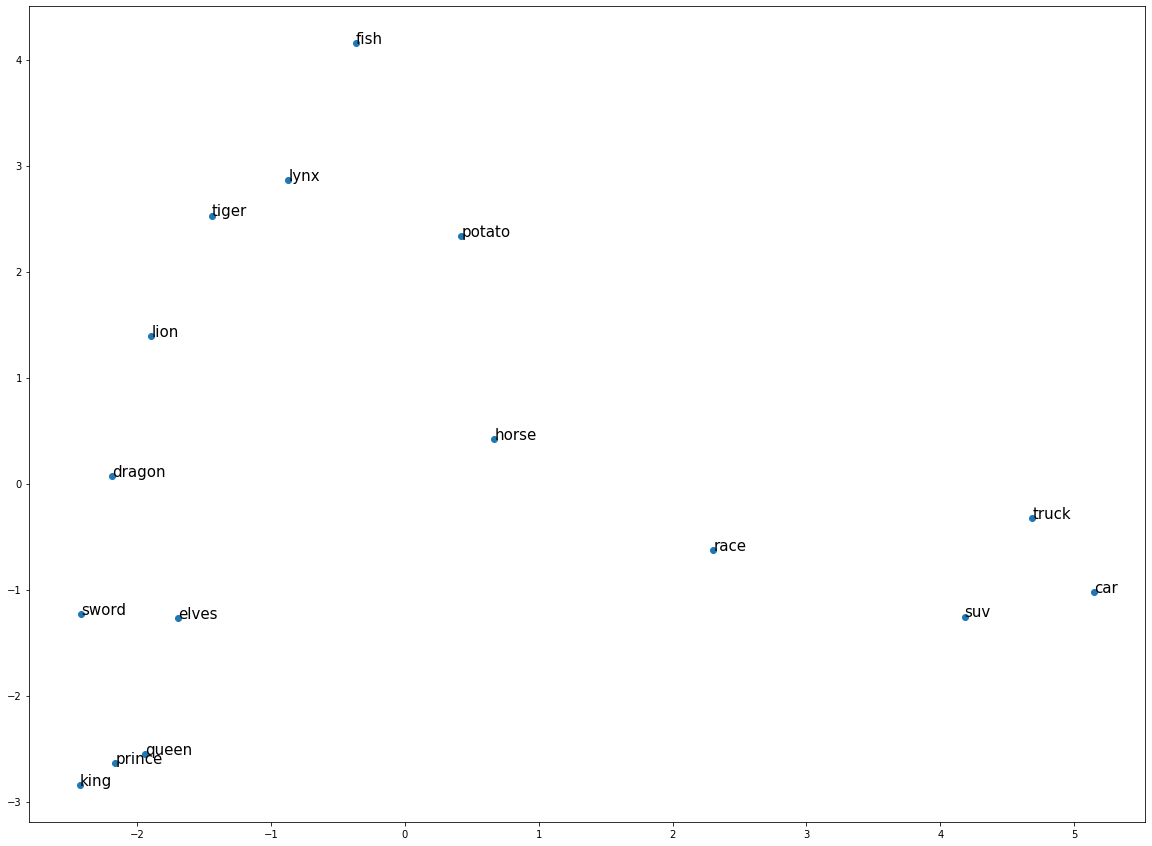

In [ ]:
# create a nice big plot 
plt.figure(figsize=(20,15))

# plot the scatter plot of where the words will be
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])

# for each word and coordinate pair: draw the text on the plot
for word, coord in zip(words, word_vecs_2d):
    x, y = coord
    plt.text(x, y, word, size= 15)

# show the plot
plt.show()

## Follow Along
### Extract Document Vectors

Let's see how much the quality of our query will work when we try a new embedding model.

Steps:
* Extract Vectors from Each Document
* Search using KNN


In [ ]:
X = [nlp(str(d)).vector for d in data]

In [ ]:
pd.DataFrame(X).shape

(401, 300)

## Challenge

You will extract word embeddings from documents using Spacy's pre-trained model in the upcoming module project. 

# Review
For your module project assignment you will create vector representations of indeed.com Data Science job listings. You will then estimate a similarity model to perform searches for job descriptions. Get started with your [module project here](./LS_DS_412_Vector_Representations_Assignment.ipynb)

# Sources

* Spacy 101 - https://course.spacy.io
* NLTK Book - https://www.nltk.org/book/
* An Introduction to Information Retrieval - https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf